# Experiment: Online Classification

In this exemplary experiment we use float to compare three online classifiers with respect to different performance measures.

In [1]:
# Optional: Rebase the file path.
# Note that you may also provide explicit file paths and avoid this step.
import os
os.chdir(os.getcwd()[:-18])

In [2]:
# Import modules
import matplotlib.pyplot as plt
from sklearn.metrics import zero_one_loss, precision_score
from sklearn.preprocessing import MinMaxScaler
from skmultiflow.trees import HoeffdingTreeClassifier, HoeffdingAdaptiveTreeClassifier
from skmultiflow.neural_networks.perceptron import PerceptronMask

# Import float modules
from float.data import DataLoader
from float.data.preprocessing import SklearnScaler
from float.pipeline import PrequentialPipeline
from float.prediction.skmultiflow import SkmultiflowClassifier
from float.prediction.evaluation import PredictionEvaluator
from float.prediction.evaluation.measures import noise_variability
import float.visualization as fvis

In [3]:
# - Create a data loader object -
# We load the Electricity data set and specify a sklearn MinMaxScaler for the normalization.
data_loader = DataLoader(path='float/data/datasets/electricity.csv',  # This path might have to be adjusted!
                         target_col=-1,
                         scaler=SklearnScaler(MinMaxScaler())
                         )

# - Create the predictor object for each classifier that we want to compare.-
# We use the default parameters of the skmultiflow classifiers, however you can provide any configuration you like.
predictors = [SkmultiflowClassifier(model=PerceptronMask(), classes=data_loader.stream.target_values),
              SkmultiflowClassifier(model=HoeffdingTreeClassifier(), classes=data_loader.stream.target_values),
              SkmultiflowClassifier(model=HoeffdingAdaptiveTreeClassifier(), classes=data_loader.stream.target_values),
              ]

# - Create evaluator objects corresponding to each classifier. -
# These evaluators will compute and store the performance measures when running the pipeline.
# We specify a fading factor and a sliding window, i.e. the evaluator will additionally store aggregated measures.. 
# ..with an exponential decay and in a sliding window.
# Note you can hand any parameter of a measure functions directly to the Evaluator, e.g. we set the zero_division..
# ..parameter of the precision_score and the reference_measure and n_samples parameters of the noise_variability.
pred_evaluators = [PredictionEvaluator(measure_funcs=[zero_one_loss, precision_score, noise_variability],
                                       decay_rate=0.1,
                                       window_size=25,
                                       zero_division=0,
                                       reference_measure=zero_one_loss,
                                       n_samples=15),
                  PredictionEvaluator(measure_funcs=[zero_one_loss, precision_score, noise_variability],
                                      decay_rate=0.1,
                                      window_size=25,
                                      zero_division=0,
                                      reference_measure=zero_one_loss,
                                      n_samples=15),
                  PredictionEvaluator(measure_funcs=[zero_one_loss, precision_score, noise_variability],
                                      decay_rate=0.1,
                                      window_size=25,
                                      zero_division=0,
                                      reference_measure=zero_one_loss,
                                      n_samples=15)]  # We evaluate each classifier w.r.t the same measures.

# - Run the Experiments for each classifier -
for model, evaluator in zip(predictors, pred_evaluators):
    # - Create a prequential pipeline -
    # We use a batch-incremental scheme, processing the data in batches of size 100.
    # Moreover, we pretrain the classifiers on 200 observations and set a random state for reproducibility.
    pipeline = PrequentialPipeline(data_loader=data_loader,
                                   predictor=model,
                                   prediction_evaluator=evaluator,
                                   batch_size=100,
                                   n_pretrain=200,
                                   n_max=data_loader.stream.n_samples,  # We use all observations
                                   random_state=0)
    pipeline.run()

Pretrain the predictor with 200 observation(s).
[====================] 100%
################################## SUMMARY ##################################
Evaluation has finished after 5.37134575843811s
Data Set float/data/datasets/electricity.csv
The pipeline has processed 45312 instances in total, using batches of size 100.
----------------------
Prediction:
| Model          |   Avg. Test Comp. Time |   Avg. Train Comp. Time |   Avg. zero_one_loss |   Avg. precision_score |   Avg. noise_variability |
|----------------|------------------------|-------------------------|----------------------|------------------------|--------------------------|
| PerceptronMask |             0.00020332 |             0.000804444 |             0.283245 |               0.786838 |                0.0982591 |
#############################################################################
Pretrain the predictor with 200 observation(s).
[====================] 100%
################################## SUMMARY ######

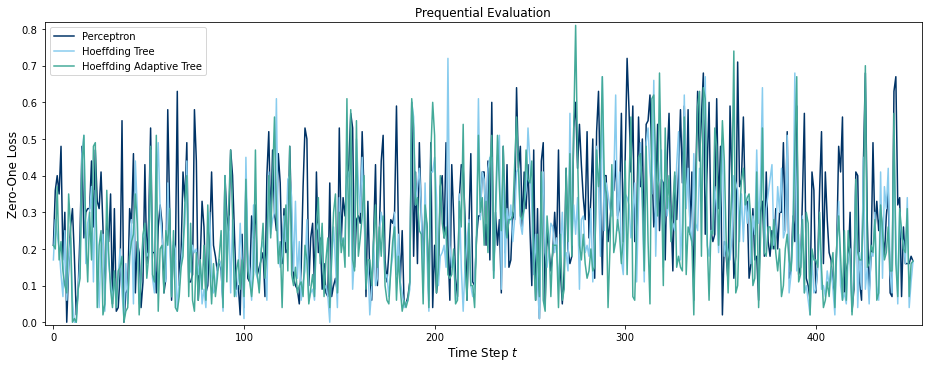

In [6]:
# - Illustrate results - 
# The evaluator objects contain all results, e.g. performance measures, calculated during the pipeline run.
# Float provides standardized plot types that may be used to illustrate these results. 
# However, note that you can essentially do whatever you like with the evaluator object, e.g. save it or create custom tables.

# - Plot the zero_one_loss -
ax = fvis.plot(measures=[evaluator.result['zero_one_loss']['measures'] for evaluator in pred_evaluators],
               legend_labels=['Perceptron', 'Hoeffding Tree', 'Hoeffding Adaptive Tree'],
               fig_size=(13, 5),
               y_label='Zero-One Loss')

ax.set_title('Prequential Evaluation')  # The returned matplotlib object can be altered and further customized.

#plt.savefig('float/experiments/zero_one_loss.pdf', bbox_inches='tight', format='pdf')  # We may also save the image.
plt.show()

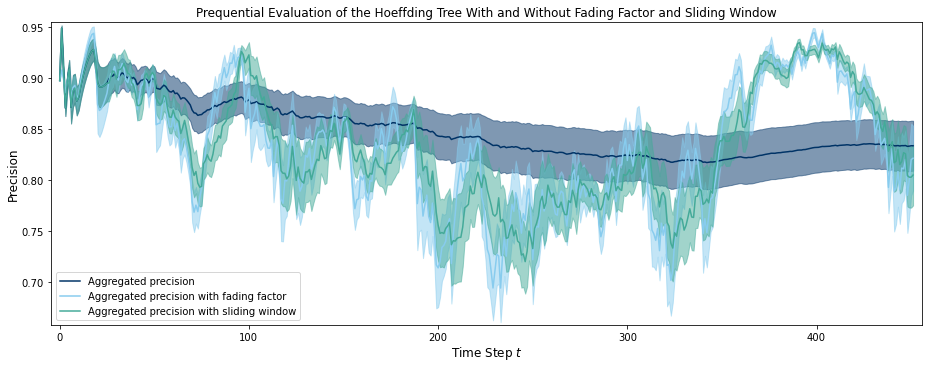

In [11]:
# - Plot the precision scores -
# This time, we want to compare the aggregated results of the Hoeffding Tree. 
# Specifically, we compare the aggregated mean and variance (where each sample has equal weight) and the.. 
# ..mean and variance for a sliding window and fading factor aggregation.
ax = fvis.plot(measures=[pred_evaluators[1].result['precision_score']['mean'], 
                         pred_evaluators[1].result['precision_score']['mean_decay'],
                         pred_evaluators[1].result['precision_score']['mean_window']
                        ],
               variance_measures=[pred_evaluators[1].result['precision_score']['var'], 
                                  pred_evaluators[1].result['precision_score']['var_decay'],
                                  pred_evaluators[1].result['precision_score']['var_window']
                                 ],
               legend_labels=['Aggregated precision', 
                              'Aggregated precision with fading factor', 
                              'Aggregated precision with sliding window'
                             ],
               fig_size=(13, 5),
               y_label='Precision')

ax.set_title('Prequential Evaluation of the Hoeffding Tree With and Without Fading Factor and Sliding Window')

#plt.savefig('float/experiments/precision_decay.pdf', bbox_inches='tight', format='pdf')  # We may also save the image.
plt.show()

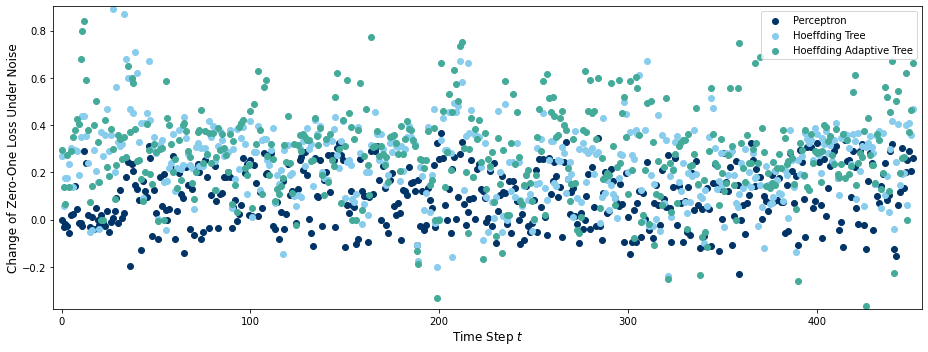

In [12]:
# - Plot the noise variability -
# Besides a line plot, float offers custom version of the standard plot types scatter and bar.
# Next, we illustrate a scatter plot of noise-variability measures over time 
# NOTE that a different plot type would typically be more meaningful!

fvis.scatter(measures=[evaluator.result['noise_variability']['measures'] for evaluator in pred_evaluators],
             legend_labels=['Perceptron', 'Hoeffding Tree', 'Hoeffding Adaptive Tree'],
             fig_size=(13, 5),
             y_label='Change of Zero-One Loss Under Noise')

ax.set_title('Variability of the Model Under Input Noise')

#plt.savefig('float/experiments/noise_variability.pdf', bbox_inches='tight', format='pdf')  # We may also save the image.
plt.show()